In [1]:
import pandas as pd

dataFilePath = '../../data/ncdatachallenge-2021-v1-1-.csv'

df = pd.read_csv(dataFilePath)

In [2]:
condition_pregnant = df['outcome'] == 'pregnant'
n_cycles_pregnant = df.loc[condition_pregnant, 'n_cycles_trying']

condition_not_pregnant = df['outcome'] == 'not_pregnant'
n_cycles_not_pregnant = df.loc[condition_not_pregnant, 'n_cycles_trying']

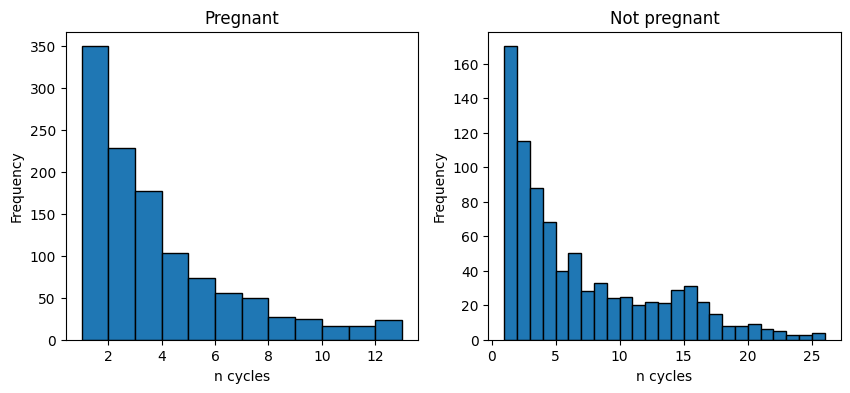

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(n_cycles_pregnant, bins=range(min(n_cycles_pregnant), max(n_cycles_pregnant) + 1), edgecolor='black')
axes[0].set_xlabel('n cycles')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pregnant')

axes[1].hist(n_cycles_not_pregnant, bins=range(min(n_cycles_not_pregnant), max(n_cycles_not_pregnant) + 1), edgecolor='black')
axes[1].set_xlabel('n cycles')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Not pregnant')

plt.savefig('plots/pregnancy_vs_cycles.pdf')

plt.show()

In [4]:
import numpy as np

print(f'Mean time   = {n_cycles_pregnant.mean()} cycles')
print(f'Rms time    = {np.sqrt(n_cycles_pregnant.var())} cycles')
print(f'Median time = {n_cycles_pregnant.median()} cycles')

Mean time   = 3.3754355400696863 cycles
Rms time    = 2.733305078852373 cycles
Median time = 2.0 cycles


In [5]:
from sklearn.preprocessing import LabelEncoder

alphanumerical_columns = ['country', 'been_pregnant_before', 'education', 'sleeping_pattern', 'outcome', 'regular_cycle']

label_encoder = list()
for column in alphanumerical_columns:
    new_label_encoder = LabelEncoder()
    df[column] = new_label_encoder.fit_transform(df[column])
    label_encoder.append(new_label_encoder)

for i in range(len(label_encoder)):    
    print(f'{alphanumerical_columns[i]}: {label_encoder[i].classes_}')

country: ['AE' 'AO' 'AR' 'AT' 'AU' 'BE' 'BR' 'CA' 'CH' 'CL' 'DE' 'DK' 'EE' 'ES'
 'FI' 'FO' 'FR' 'GB' 'HU' 'IE' 'IL' 'IS' 'KE' 'MT' 'MY' 'NL' 'NO' 'NZ'
 'PL' 'PT' 'SE' 'SI' 'US' 'ZA' nan]
been_pregnant_before: ['No, never' 'Yes 3 times or more' 'Yes, once' 'Yes, twice' nan]
education: ['Elementary school' 'High school' 'PhD'
 'Trade/technical/vocational training' 'University' nan]
sleeping_pattern: ['Late and snoozer' 'Several times during the night' 'Shift worker'
 'Wake same every day' 'Wake same every workday' nan]
outcome: ['not_pregnant' 'pregnant']
regular_cycle: [False True nan]


In [6]:
print(df)

        id        bmi  age  country  been_pregnant_before  education  \
0        0  22.942130   31       30                     0          4   
1        1  19.886054   34       34                     4          4   
2        2  29.323049   41       30                     0          4   
3        3  24.386526   27       30                     0          1   
4        4  29.299971   29       30                     0          3   
...    ...        ...  ...      ...                   ...        ...   
1990  1996  24.867781   36       17                     2          2   
1991  1997  21.616406   32       17                     0          5   
1992  1998  24.218750   23       30                     4          1   
1993  1999  21.453574   30       14                     0          4   
1994  2000  19.948690   29       30                     0          4   

      sleeping_pattern  n_cycles_trying  outcome  dedication  \
0                    4                1        1    0.640000   
1      

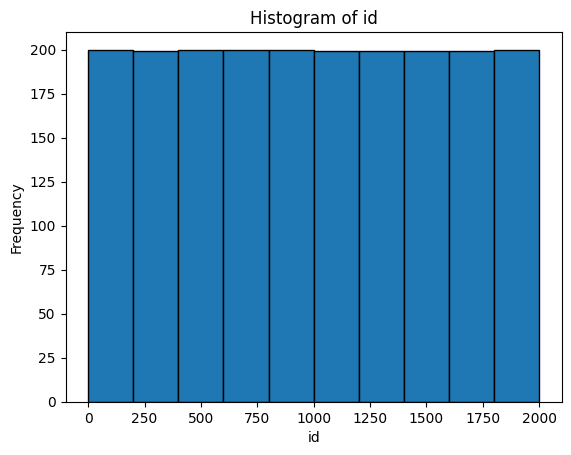

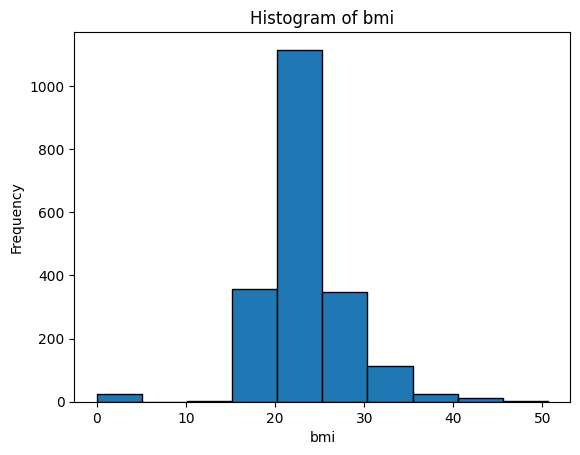

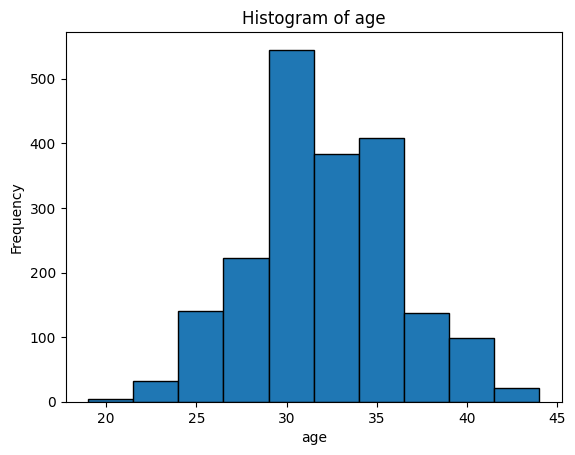

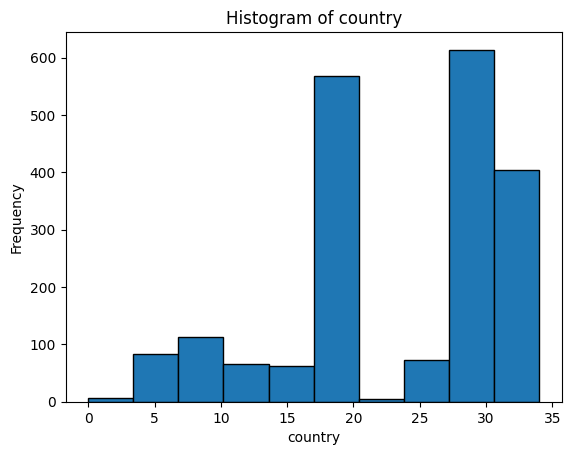

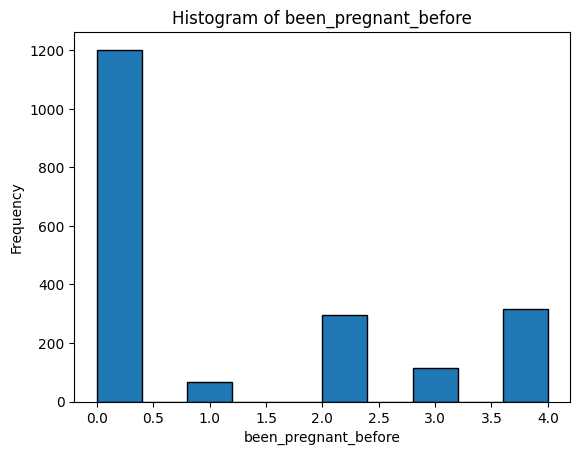

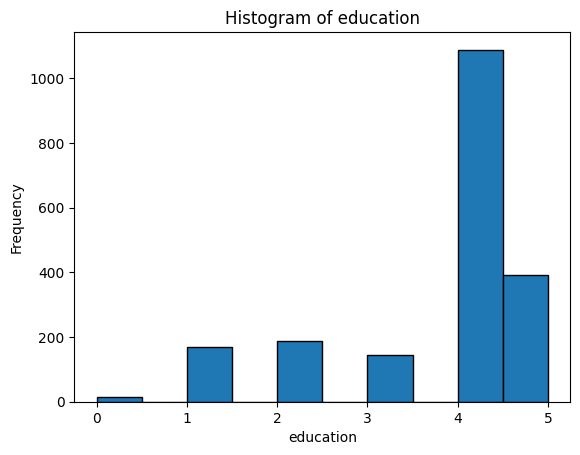

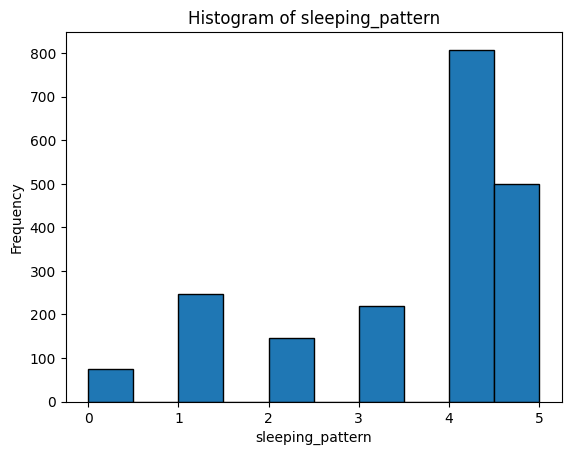

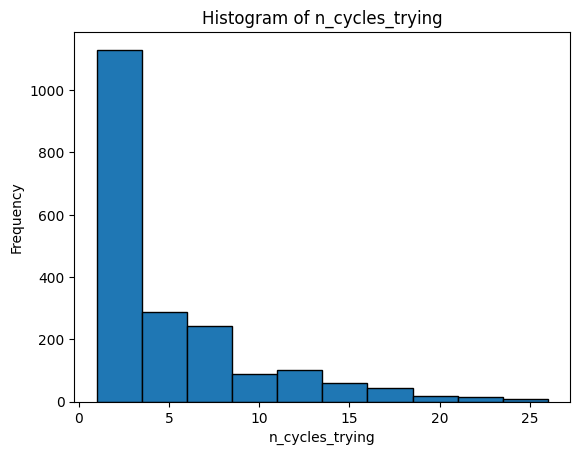

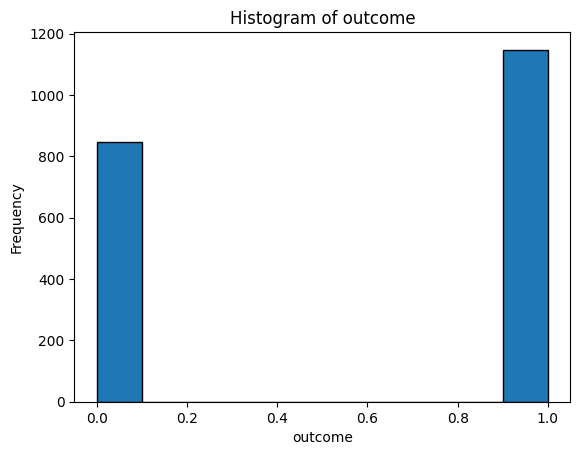

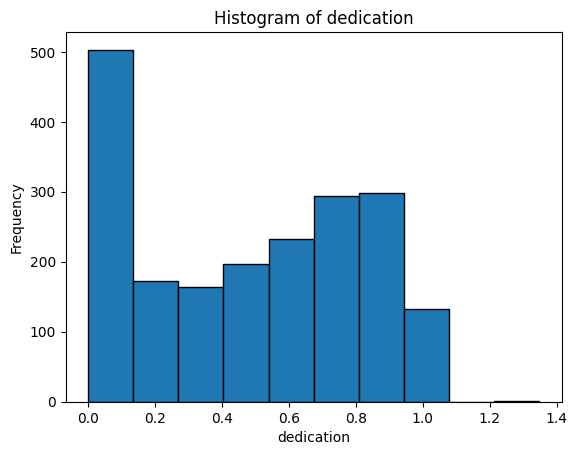

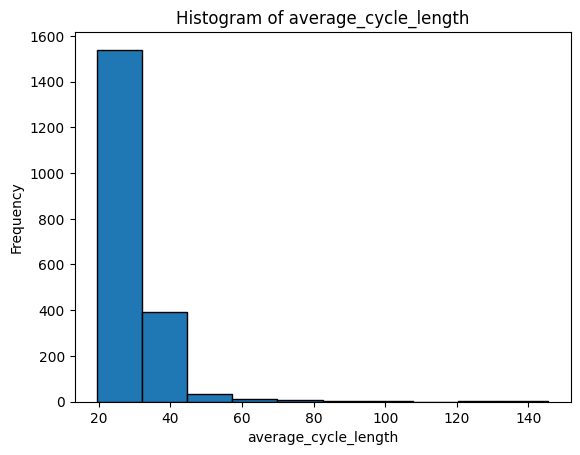

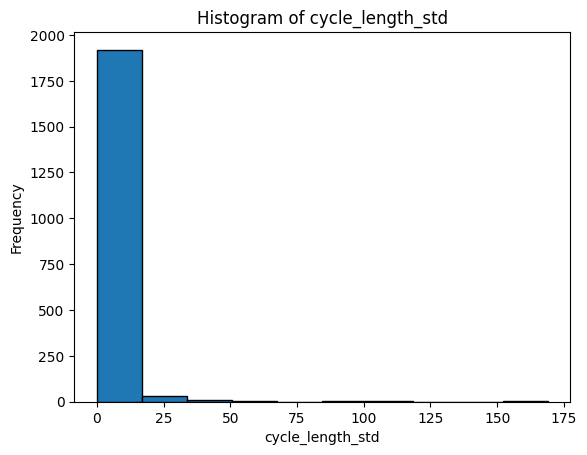

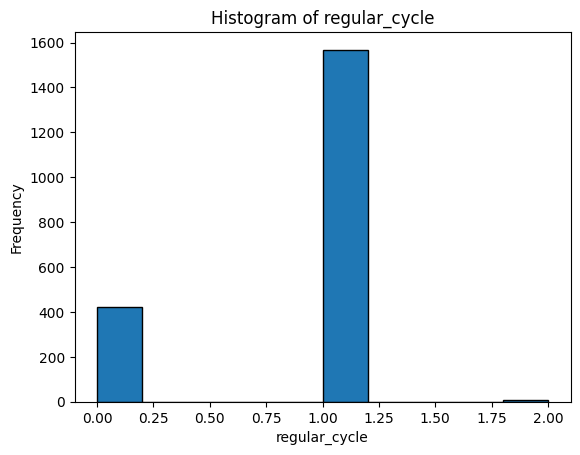

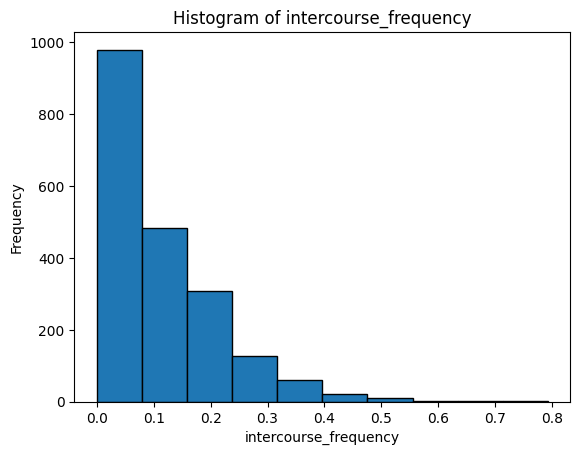

In [7]:
for column in df.columns:
    value_counts = df[column].value_counts()
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [8]:
'''
Reinserting NaN's
'''

for i in range(len(label_encoder)):    
    nan_index = len(label_encoder[i].classes_)-1
    value = label_encoder[i].classes_[nan_index]
    print(nan_index, " -> ", type(value))
    if isinstance(value, float):
        df.loc[df[alphanumerical_columns[i]] == nan_index, alphanumerical_columns[i]] = np.nan

nan_counts = df.isna().sum()
print("NaN counts in each column:")
print(nan_counts)

print(df)

34  ->  <class 'float'>
4  ->  <class 'float'>
5  ->  <class 'float'>
5  ->  <class 'float'>
1  ->  <class 'str'>
2  ->  <class 'float'>
NaN counts in each column:
id                         0
bmi                        0
age                        0
country                  113
been_pregnant_before     317
education                391
sleeping_pattern         499
n_cycles_trying            0
outcome                    0
dedication                 0
average_cycle_length       6
cycle_length_std          25
regular_cycle              6
intercourse_frequency      0
dtype: int64
        id        bmi  age  country  been_pregnant_before  education  \
0        0  22.942130   31     30.0                   0.0        4.0   
1        1  19.886054   34      NaN                   NaN        4.0   
2        2  29.323049   41     30.0                   0.0        4.0   
3        3  24.386526   27     30.0                   0.0        1.0   
4        4  29.299971   29     30.0                   0.0

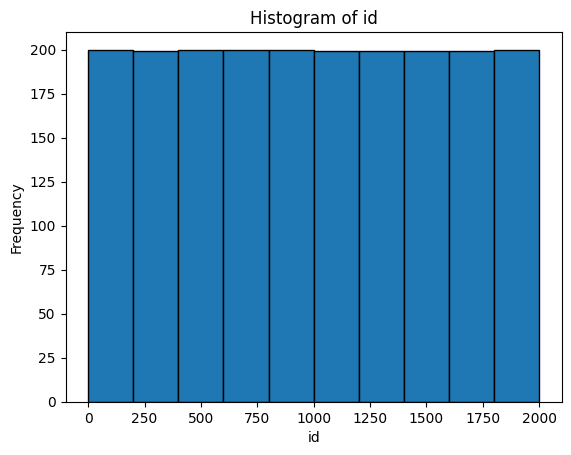

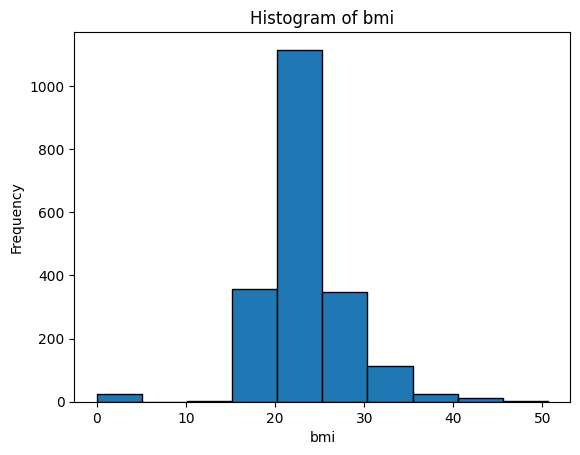

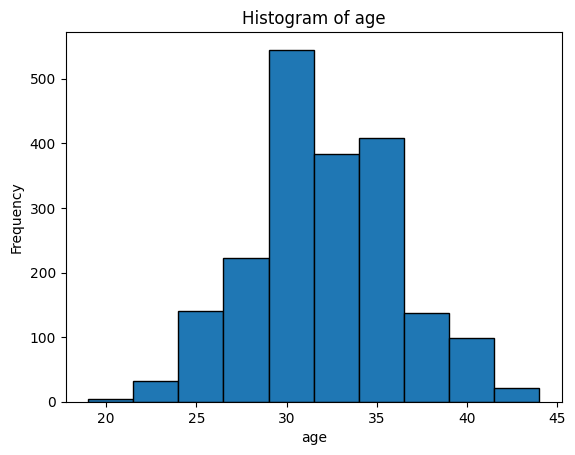

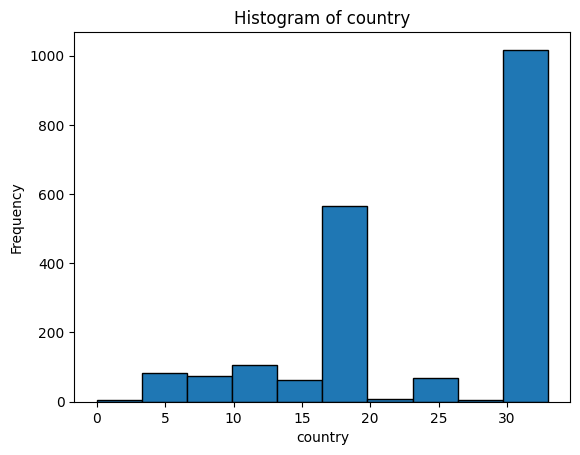

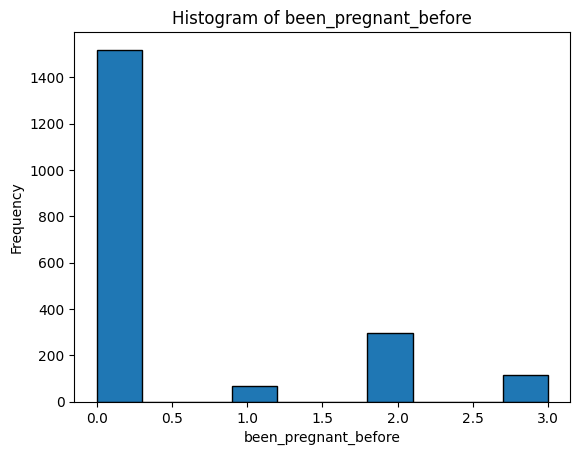

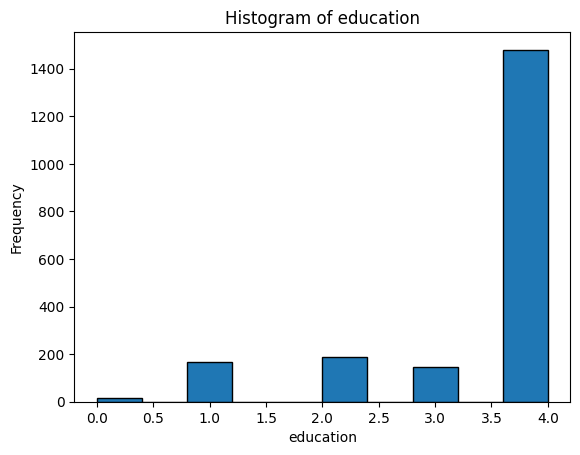

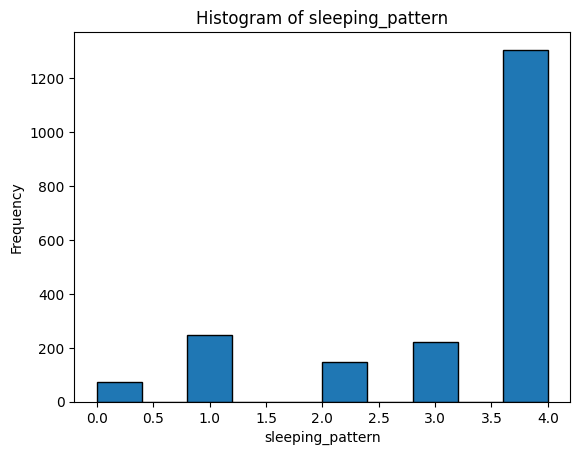

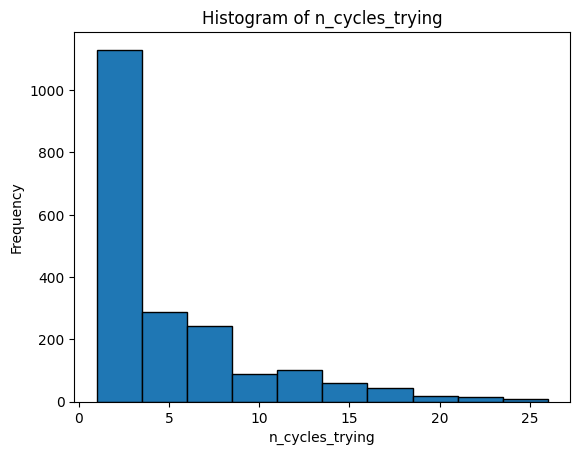

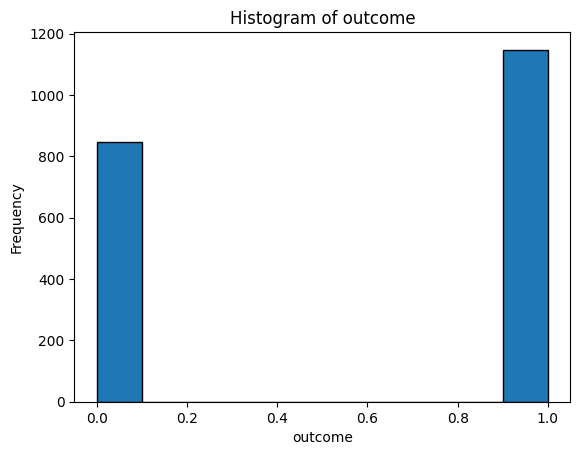

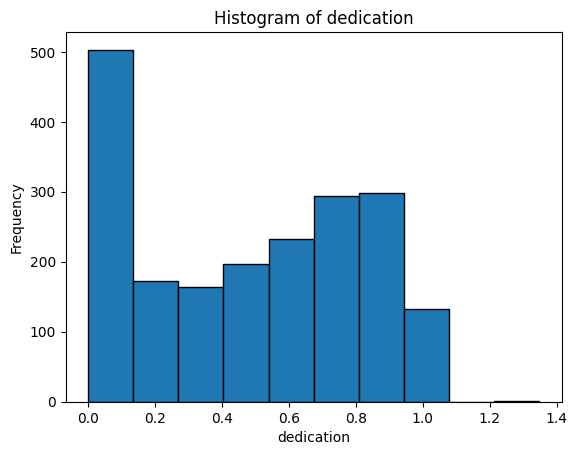

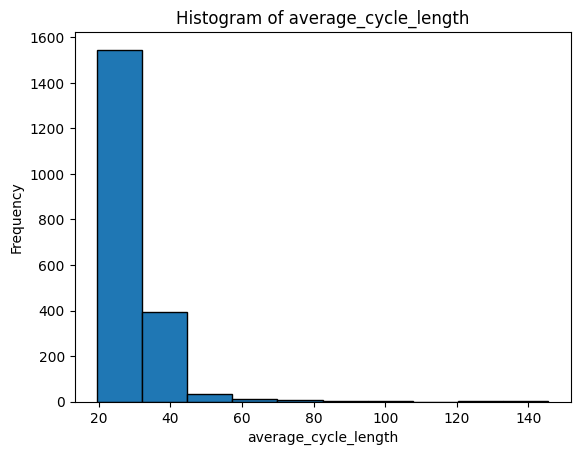

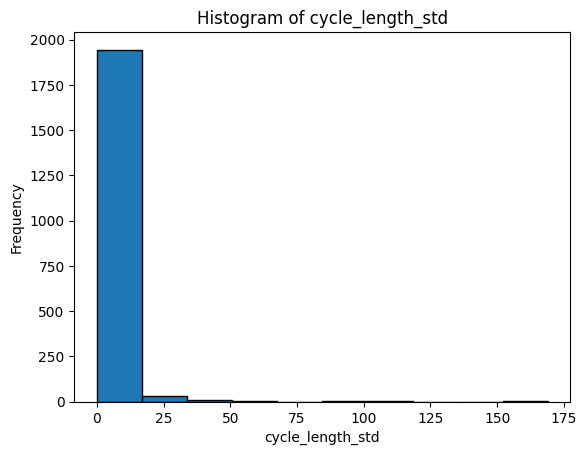

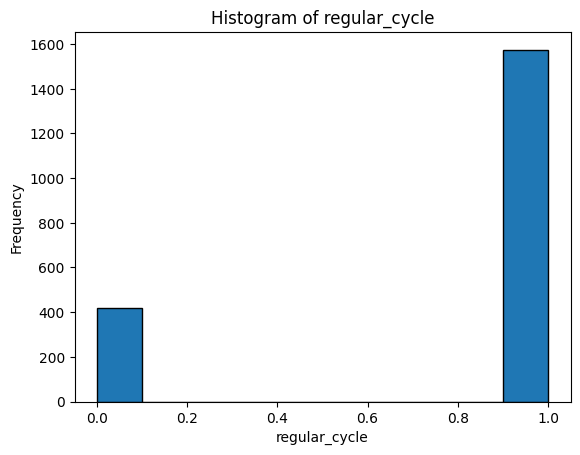

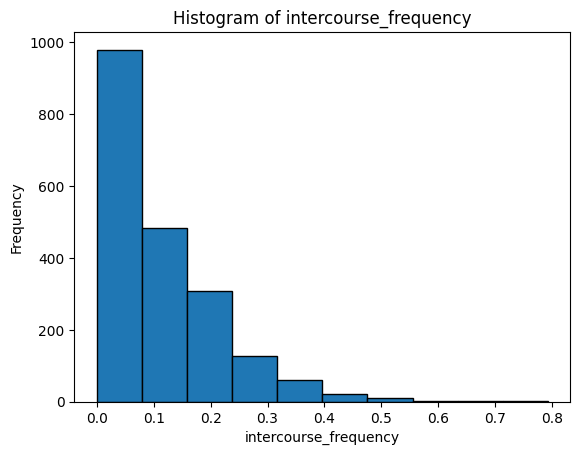

In [9]:
'''
Substituting NaN's with statistical sample
'''

for column in df.columns:
    value_counts = df[column].dropna().value_counts()
    #print(value_counts)
    values = value_counts.index
    probabilities = value_counts / value_counts.sum()
    random_number = np.random.choice(values, p=probabilities)
    #print('RRRRRRRRRRRRRRRRRRRRRRRRR = ', random_number)
    df.loc[np.isnan(df[column]), column] = random_number
'''
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()
    '''

for column in df.columns:
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [12]:
'''
One-hot is better than label encoding, because there's no numerical contiguity in the values
'''

for column in alphanumerical_columns:
    df = pd.get_dummies(df, columns=[column], prefix=column)
    
print(df)
#df.to_csv('tmp.csv', index=False)

        id        bmi  age  n_cycles_trying  dedication  average_cycle_length  \
0        0  22.942130   31                1    0.640000             25.588235   
1        1  19.886054   34                7    0.009569             30.875000   
2        2  29.323049   41                4    0.298246             27.666667   
3        3  24.386526   27                2    0.895833             24.250000   
4        4  29.299971   29                2    0.666667             25.466667   
...    ...        ...  ...              ...         ...                   ...   
1990  1996  24.867781   36                1    0.000000             30.250000   
1991  1997  21.616406   32                2    0.843750             31.166667   
1992  1998  24.218750   23               20    0.540187             26.629630   
1993  1999  21.453574   30                1    0.000000             38.600000   
1994  2000  19.948690   29                2    0.779661             29.909091   

      cycle_length_std  int

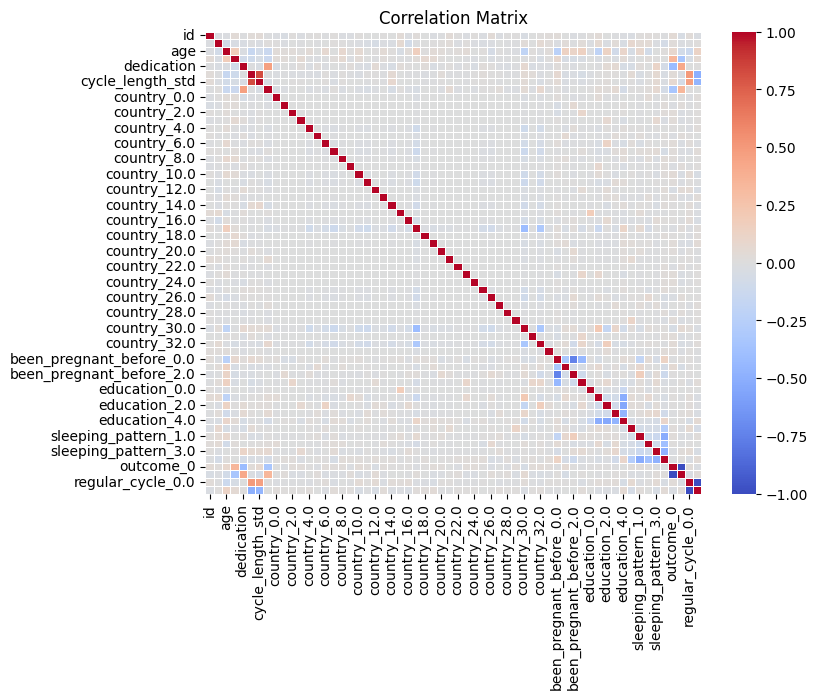

In [14]:
import seaborn as sns

correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

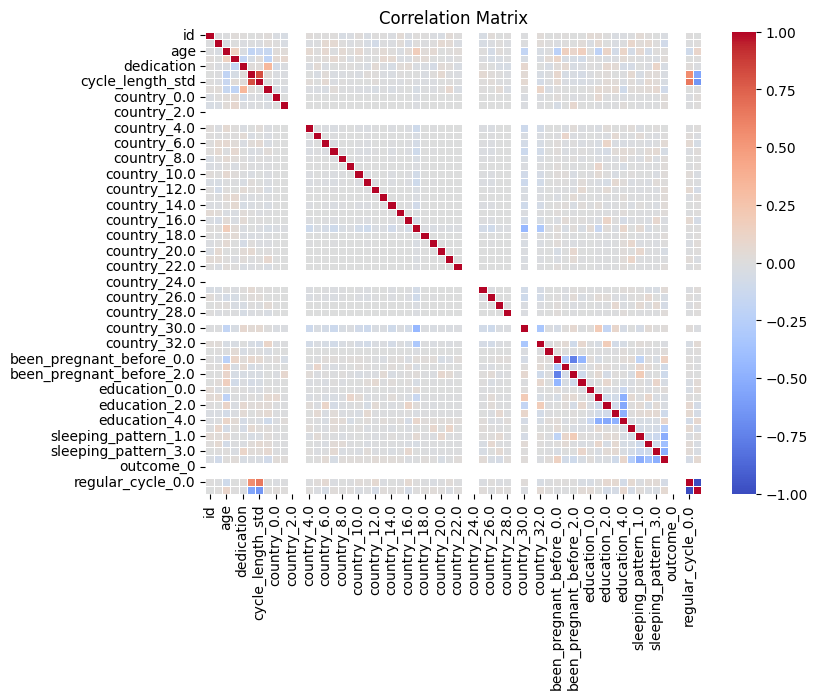

In [16]:
'''
THIS ONE IS USELESS AT THIS POINT
'''

condition = df['outcome_1'] == 1
df_pregnant = df[condition]

correlation_matrix = df_pregnant.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

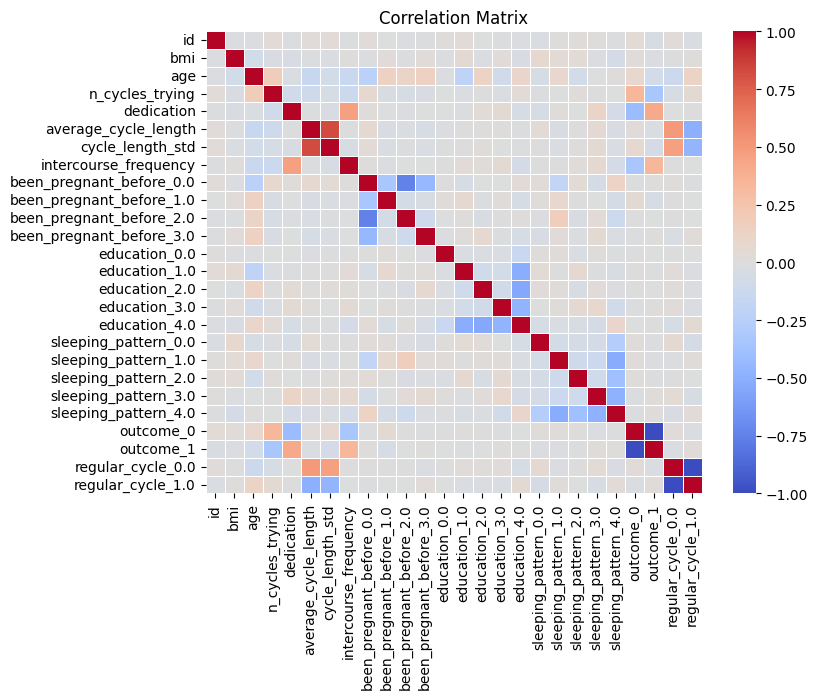

In [18]:
regex_to_exclude = 'country*'
filtered_df = df.filter(regex=f'^(?!{regex_to_exclude}).*$', axis=1)

correlation_matrix = filtered_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()